# Diffusion-based Speech Enhancement Demo

This demo presents advanced techniques in speech enhancement using deep generative models.

We compare SGMSE+ [1] with Schrödinger bridge approaches [2, 3]. 

The presented methods focus on generating high-quality super-wideband speech at a sampling rate of 48 kHz. 

Participants will record speech using a single microphone in a noisy environment, such as a conference venue. 

These recordings will then be enhanced and played back through headphones. 

We aim to demonstrate the model's effectiveness in improving speech quality and intelligibility.

```text
[1] J. Richter, S. Welker, J.-M. Lemercier, B. Lay, and T. Gerkmann, 
    “Speech enhancement and dereverberation with diffusion-based generative models,” 
    IEEE/ACM Transactions on Audio, Speech, and Language Processing, vol. 31, pp. 2351–2364, 2023.

[2] A. Jukić, R. Korostik, J. Balam, and B. Ginsburg, 
    “Schrödinger bridge for generative speech enhancement,” 
    Proceedings of Interspeech, pp. 1175-1179, 2024.    

[3] Julius Richter, Danilo de Oliveira, Timo Gerkmann, 
    “Investigating Training Objectives for Generative Speech Enhancement,”
    submitted to IEEE International Conference on Acoustics, Speech, and Signal Processing.
```

## Load packages

In [1]:
import os
import torch
import numpy as np
import soundfile as sf
import ipywidgets as widgets

from sgmse.model import ScoreModel
from sgmse.util.other import pad_spec
from sgmse.util.visualization import plot_spec, plot_spec_dual

from IPython.display import display, Audio

# Set device
os.environ["CUDA_VISIBLE_DEVICES"]="0"

## Download the pre-trained models

In [ ]:
if not os.path.exists('checkpoints'):
    os.makedirs('checkpoints')
    !wget -P checkpoints https://www2.informatik.uni-hamburg.de/sp/audio/publications/neurips2024-demo/checkpoints/sgmse.ckpt
    !wget -P checkpoints https://www2.informatik.uni-hamburg.de/sp/audio/publications/neurips2024-demo/checkpoints/sb.ckpt
    !wget -P checkpoints https://www2.informatik.uni-hamburg.de/sp/audio/publications/neurips2024-demo/checkpoints/sb-pesq.ckpt

## Load models

In [2]:
sb_checkpoint = '/data3/jrichter/logs/sgmse_logs/neurips2024/checkpoints/sb.ckpt'
sb_pesq_checkpoint = '/data3/jrichter/logs/sgmse_logs/neurips2024/checkpoints/sb-pesq.ckpt'
sgmse_checkpoint = '/data3/jrichter/logs/sgmse_logs/neurips2024/checkpoints/sgmse.ckpt'

sb_model = ScoreModel.load_from_checkpoint(sb_checkpoint)
sb_pesq_model = ScoreModel.load_from_checkpoint(sb_pesq_checkpoint)
sgmse_model = ScoreModel.load_from_checkpoint(sgmse_checkpoint)

In [3]:
file_path = '/data3/databases/EARS-WHAM/test/noisy/p106/00000_-1.9dB.wav'
audio, sr = sf.read(file_path)

## Inference

In [4]:
model_slider = widgets.Dropdown(options=['SGMSE+', 'SB', 'SB-PESQ', ], value='SGMSE+', description='Model:', disabled=False)
sampler_type_slider = widgets.Dropdown(options=['ODE', 'SDE'], value='SDE', description='Sampler:', disabled=False)
N_slider = widgets.SelectionSlider(options=[1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50], value=30, description='N:', disabled=False, continuous_update=False, orientation='horizontal', readout=True)

display(model_slider)
display(sampler_type_slider)
display(N_slider)

Dropdown(description='Model:', options=('SGMSE+', 'SB', 'SB-PESQ'), value='SGMSE+')

Dropdown(description='Sampler:', index=1, options=('ODE', 'SDE'), value='SDE')

SelectionSlider(continuous_update=False, description='N:', index=6, options=(1, 5, 10, 15, 20, 25, 30, 35, 40,…

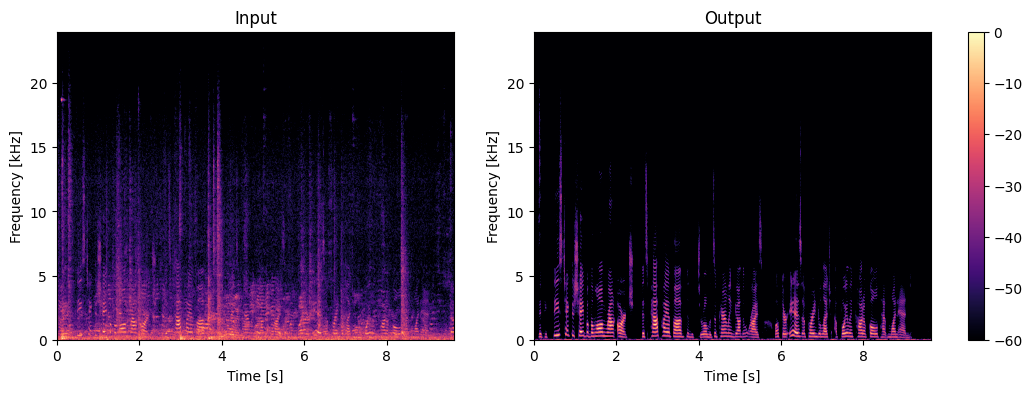

In [5]:
# Settings
if model_slider.value == 'SGMSE+':
    model = sgmse_model
elif model_slider.value == 'SB':
    model = sb_model
elif model_slider.value == 'SB-PESQ':
    model = sb_pesq_model

if sampler_type_slider.value == 'ODE':
    sampler_type = 'ode'
elif sampler_type_slider.value == 'SDE':
    sampler_type = 'sde'

N = N_slider.value

# Transfer audio to GPU
audio_tensor = torch.tensor(audio, dtype=torch.float32).unsqueeze(0).cuda()

# Enhance audio
x_hat = model.enhance(audio_tensor, sampler_type=sampler_type, N=N)

# Play enhanced audio
display(Audio(audio, rate=sr))
display(Audio(x_hat, rate=sr))
plot_spec_dual(audio, sr, x_hat, sr, target_sr=sr)